# Building Computational Skeleton Blocks with Neural Tangent Kernel 



##Bayesian Neural Network with Blocks

Understanding the flow of information in Neural networks and identifying which input data has an impact on the prediction has become a hugely important part of modern deep learning research. Ongoing research, such as causal inference and [local elasticity](https://deepai.org/publication/the-local-elasticity-of-neural-networks) of the neural network has been tackling this problem. In that context, we proposed our model with style, building a deep probabilistic model with the structure called computational skeleton to provide the ability to understand the flow of information in probabilistic models as well as the opportunity of identifying statistical interactions to obtain interpretable models.

By building a Bayesian neural network with blocks, we provided the framework that could tie various deep probabilistic models together including BNNs, DGPs, DKL, and others using our blocks, namely, function blocks and random feature blocks. From the experiment, we proved that the prediction performance of our main model BANN competes favorably compared to other probabilistic models. Moreover, with our additive structure, we were able to obtain interpretable models with uncertainty measures via statistical interactions.


##Neural Tangent Kernel

In the field of the theoretical study of Neural networks, the study about Neural networks showing comparable aspects to Gaussian processes in the infinite-width limit has been a high-yielding area recently. This work shows that the parameters in a wide neural network tend to stay close to their initialization during training, and as a result, the neural net can be effectively approximated by its first-order Taylor expansion regarding parameters at initialization and provide the same character to kernel regression with respect to kernel known as Neural Tangent Kernel. From this theory, we could take the tools of kernel methods to the overparameterized neural networks.

Power using the NTK regime of work is that it proves the over-parameterized neural networks can efficiently learn with fast convergence and as good generalization as kernels but there are still only a few things that we really know. A lot of researchers actually have been including NTK regime of work in their research to show translating [other architecture](https://arxiv.org/abs/1904.11955) into kernel learning, overcome [limits](https://arxiv.org/pdf/2002.04026v2.pdf) on using NTK setting, and present [alternatives](https://arxiv.org/pdf/2009.10683.pdf) of NTK. It is clear that it has brought some new perspective to understand more about deep neural networks in an infinite width limit.

##Building Computational Skeleton Blocks with NTK parameterization

Given this emerging topic in the field, it is only reasonable to relate our work with Neural Tangent Kernel since our model has the ability to flexibly relate with DGP and DKL models. From this experiment, we propose a concrete *discussion* regarding how our architecture performs and what it offers when used with NTK parameterization. 

Our experiment was inspired by the recent studies about how they can achieve what NTK based analysis can achieve, for example generalization, without using kernel-based methods. [Allen-Zhu et al.](https://arxiv.org/pdf/1905.10337.pdf) propose hierarchical learning using three-layer residual networks with smooth activations, in a distributional free setting to achieve better generalization ability than the kernel method using NTK. The hierarchy learning network is constructed similar to our computational skeleton in which the first hidden layer serves to learn simple features and the second hidden layer learns complex features with help of what they learned prior. Additionally, they are not separate and rather disentangled with combined functions. They are also trained simultaneously, which is similar to our multi-task learning. Since our BANN implicitly performs multi-task learning via the architecture, we decided to translate our BANN model into an infinite-width neural network using NTK to provide hierarchy on NTK settings and see how it performs.

However, it was not plausible to directly translate our model into an infinite-width neural network, since our BANN model already had defined the kernel via blocks and fixed weight space. Therefore, it was reasonable to take only the blocks and architecture, computational skeleton, and apply NTK parameterization. This way we could achieve the advantage of multi-task learning and obtain infinite-width inference at the same time. Taking this idea into account, we designed our new experiment. In this experiment, we first define the neural network with a computational skeleton consisting of Random feature blocks and Function blocks to compute infinite-width GP kernels corresponding to our architecture. Then, we take these kernels to perform exact Bayesian inference using the infinite-width network. Two kernels will be used which are, NNGP(Neural Network Gaussian Process) kernel that describes Bayesian infinite network will be used to compute [Bayesian posterior](https://arxiv.org/abs/2007.05864) and NTK kernel to compute the distribution of networks after gradient descent training. Finally, we compare our result with the basic set of architecture, wider 3-layer network, and see how our architecture performs on generalization power and ability to capture uncertainties. 


##Result and Discussion

The result shows that our architecture and multi-task learning works favorably with the NTK parameterization. Infinite-width inference from both NNGP and NTK kernel based on our architecture showed better ability on generalization without any overfitting and capturing uncertainty measure with confidence intervals compared to a wider 3-layer network base architecture. In order to see how well it performs on generalization and detail uncertainty on out-of-distribution test data, very few noisy training data were used. We can also see that randomized prior draws by our architecture look more close to its posterior with help from our Function block which takes its part by helping us defining Bayesian priors and posteriors. To sum up, providing hierarchy on NTK settings brings several advantages including better generalization and the ability to capture significant uncertainty measures with prediction.

So far, with our architecture and kernel settings via blocks, we built a Bayesian Neural network with competitive predictive performance and showed by manipulating the blocks we could achieve flexibility in probabilistic models from BNN to DGP and DKL. Additionally, with the additive structure, we showed how we obtained interpretability via statistical interaction. From this experiment, with our architecture and Neural tangent Kernel settings, we showed we could achieve **even stronger generalization power** and fast convergence of infinite-width inference than basic architecture on the base, and on top of that, **an extensive strength on capturing predictive uncertainty**. While very few studies have been done on capturing significant uncertainty over the randomness on NTK settings, this experiment could propose a significant argument on the importance of architecture on deep probabilistic models and the impact of multi-task learning in kernel settings.



##Our Experiment

### Imports and Utils

In [ ]:
#@title
!pip install -q git+https://www.github.com/google/neural-tangents

In [ ]:
#@title
import jax.numpy as np

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools



import neural_tangents as nt
from neural_tangents import stax

In [ ]:
#@title
##Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
  
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None): 
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=10)
  if y is not None:
    plt.ylabel(y, fontsize=10)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

In [ ]:
#@title
##Plotting scheme
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=3, label='train')
  
  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [ ]:
#@title
##Loss function
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = np.reshape(mean, mean.shape[:1] + (-1,))
  var = np.diagonal(cov, axis1=1, axis2=2)
  ys = np.reshape(ys, (1, -1))

  mean_predictions = 0.5 * np.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

### Creating a noisy Dataset

For this experiment, we will use a widely used synthetic dataset that's used extensively in Pattern Recognition and Machine Learning. Our training data is going to be drawn from a process,
    $$y = f(x) + \epsilon$$
where $f(x)$ is a deterministic function and $\epsilon\sim\mathcal N(0, \sigma)$ is Gaussian noise with some scale. We're going to choose $f(x) = \sin(x)$ with $x\sim\text{Uniform}(-\pi, \pi)$. Our testing data will be $y = f(x)$ for $x$ linearly spaced in $[-\pi, \pi]$. 

In order to show the advantage of using our structure, we will use a training set of 150 points and 150 test points with a high noise scale. This scarce and noisy dataset will help us detect the strength of generalization and detail uncertainty on out-of-distribution test data.

In [ ]:
key = random.PRNGKey(2021)

In [ ]:
train_points = 150
test_points = 150
noise_scale = 5e-1

target_fn = lambda x: np.sin(x)

In [ ]:
#@title
key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

In [ ]:
#@title
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

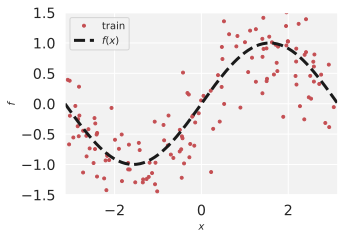

In [ ]:
#@title
plot_fn(train, test)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

### Computational Skeleton block with NTK parameterization

We now define our architecture using our computational skeleton structure. We describe our network using our neural network library layers in `neural_tangents.stax`, which will enable us to draw parameters randomly, compute output, and compute infinite-width GP kernels corresponding to the layer. We define our fully-connected layers using the `Dense` layer which is defined by,
$$z^{l+1}_i = \frac{\sigma_w}{\sqrt{N_{in}}} \sum_j W_{ij} z^{l}_i + \sigma_b b_i$$
where $W_{ij}, b_i\sim\mathcal N(0,1)$ at initialization and $\sigma_w, \sigma_b$ sets the scales of the weights and biases respectively.

Specifically, our computational skeleton block consists of a Random feature block and a Function block. `CSB` defined below is designed using `stax.Fanout` to make an additive structure that will take its part in multi-task learning by concatenating several sub neural networks. Random Feature block which we used to construct random feature approximation for kernels to leverage the expressive power of DGP on BANN will come first but with NTK parameterization for this experiment. Then, the Function block which helped us allow the node to replicate and define Bayesian approximations will come next with a dropout layer. Each block has [erf activation](https://arxiv.org/abs/1902.06720), meaning that both the NNGP and NTK kernel will be analytically available. Then we conclude our structure with an additional dropout layer and a final fully connected layer.

In [ ]:
keep_rate = 0.9 ## == dropout rate of 0.1

In [ ]:
#multi-task learning
#Computational Skeleton Block
CSB = stax.serial(
    stax.FanOut(10),
    stax.parallel(
        stax.serial(
            stax.Dense(10, parameterization='ntk'), stax.Erf(),
            stax.Dense(10), stax.Erf(),
            stax.Dropout(keep_rate)
        )
    ),
    stax.FanInConcat(1)
)


init_fn, apply_fn, kernel_fn = stax.serial(
    CSB,
    stax.Dropout(keep_rate),
    stax.Dense(1)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,)) ##use a JAX feature that compiles functions so that they are executed as single calls to the GPU.

In [ ]:
#@title
prior_draws = []
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (-1, 1))
  prior_draws += [apply_fn(params, test_xs, rng=key)]

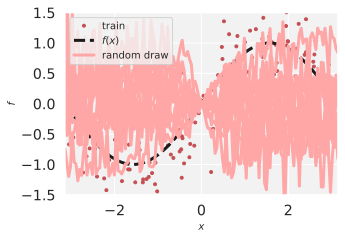

In [ ]:
#@title
plot_fn(train, test)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((0.85, 0.6))

First, to look at what functions look like we make the plot above that shows randomised prior draws of the parameters of the network.

Next, we look at the exact prior over functions in the infinite-width limit by computing the kernel between two sets of inputs `x_1` and `x_2` and compare it with the draws above.

In [ ]:
#@title
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.6/dist-packages/neural_tangents/stax.py:3967: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


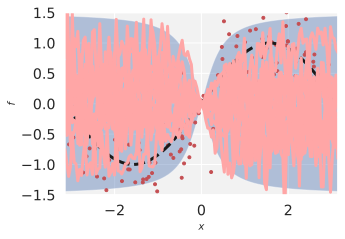

In [ ]:
#@title
plot_fn(train, test)

plt.fill_between(
    np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

### Infinite Width Inference

Now, we can use the infinite-width GP defined above to perform exact Bayesian inference using the infinite width network. Here, we will compute two different kernels which are, "NNGP" where we compute the Bayesian posterior (which is equivalent to gradient descent with all but the last-layer weights frozen), in "NTK" where we compute the distribution of networks after gradient descent training. 

In [ ]:
#@title
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, 
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp', 
                                        compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.6/dist-packages/neural_tangents/stax.py:3967: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


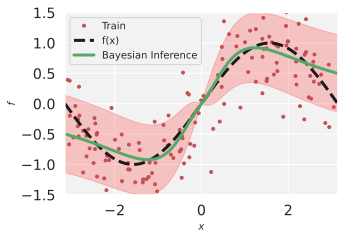

In [ ]:
#@title
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'g-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))

In [ ]:
#@title
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk', 
                                      compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.6/dist-packages/neural_tangents/stax.py:3967: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


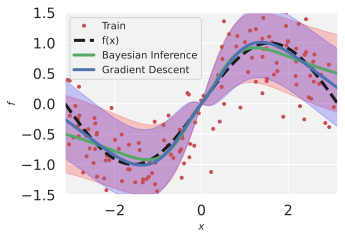

In [ ]:
#@title
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'g-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

The first plot shows the exact Bayesian inference by using the "NNGP" setting. We can see that our posterior fits pretty well with target function, even with scarce and noisy training points. We also see that there are **significant uncertainty measures** with the predictions. 

The next plot shows the result of doing gradient descent on our infinite network for an *infinite* amount of time by using the "NTK" inference mode. We can see that when compared with the result of true Bayesian inference and gradient descent the result of gradient descent and Bayesian inference are similar, but they are not identical.  

In [ ]:
#@title
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

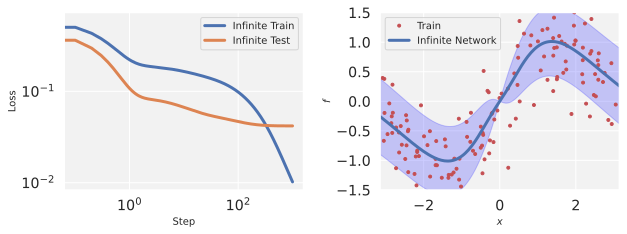

In [ ]:
#@title
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

From the final result, we can see that our structure perform splendidly to predict the target function with an extensive strength in capturing predictive uncertainty. Our structure also managed to provide strong generalization power with the scarce and noisy dataset.

### Comparison to wide 3-layer network

In order to show the advantage of using our structure with NTK, we compare our result with the result from using a basic 3-layer network with 2 hidden layers of width 512 and the final fully-connected layer. Exactly the same process was taken with the same data to make a sound comparison.

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [ ]:
prior_draws = []
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (-1, 1))
  prior_draws += [apply_fn(params, test_xs, rng=key)]

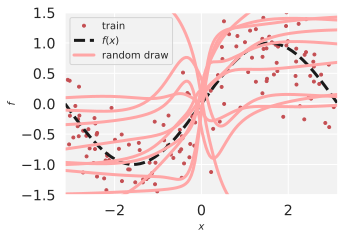

In [ ]:
#@title
plot_fn(train, test)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((0.85, 0.6))

In [ ]:
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


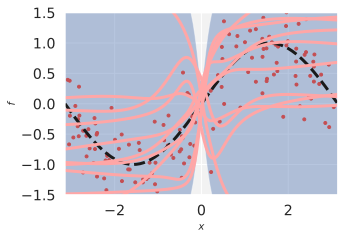

In [ ]:
#@title
plot_fn(train, test)

plt.fill_between(
    np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

From the result of infinite-width inference by using kernels based on 3-layer network architecture, we can see that the Bayesian posterior and NTK inference does not fit smoothly to the target function and has a tendency to overfit to some data point.

This proves that our computational skeleton architecture provides stronger generalization power than this base setting. Additionally, both results do not show any visible uncertainty quantification around their prediction even though they have the ability to do so.


In [ ]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, 
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp', 
                                        compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


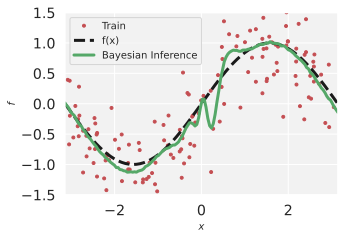

In [ ]:
#@title
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'g-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))

In [ ]:
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk', 
                                      compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


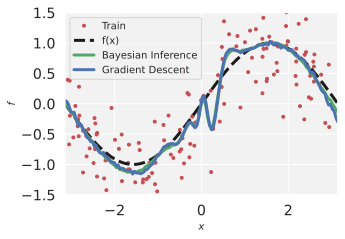

In [ ]:
#@title
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'g-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

In [ ]:
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

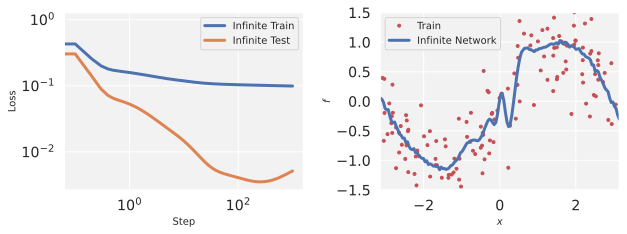

In [ ]:
#@title
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

Copyright 2019 Google LLC

*Source code based on google neural tangent kernel cookbook*